#### Explore the ready dataset Iisights,distribution,charachtristics ...

In [1]:

from modbus import ModbusDataset
import pandas as pd 
import re   
# import torch
from torch.utils.data import Dataset,DataLoader
from torch import Tensor,tensor,float32,int32
import numpy as np
# import json
from utils import merge_datasets
from collections import Counter
import matplotlib.pyplot as plt
import os 
from typing import List, Tuple
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder , LabelEncoder
import time

In [2]:
# uncommit if the Labeled_CICMODBUS2023.zip not extracted yet! 
# import zipfile
# import os

# # from Labeling notebook , This file will be achieved.
# zip_path = "./Labeled_CICMODBUS2023.zip"
# extract_dir = "./dataset"

# # Create directory if missing
# os.makedirs(extract_dir, exist_ok=True)

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)



In [3]:
dataset_directory = "./dataset" # change this to the folder contain benign and attack subdirs
modbus = ModbusDataset(dataset_directory,"ready",batch_size=5)
modbus.summary_print()

 The CIC Modbus Dataset contains network (pcap) captures and attack logs from a simulated substation network.
                The dataset is categorized into two groups: an attack dataset and a benign dataset
                The attack dataset includes network traffic captures that simulate various types of Modbus protocol attacks in a substation environment.
                The attacks are reconnaissance, query flooding, loading payloads, delay response, modify length parameters, false data injection, stacking Modbus frames, brute force write and baseline replay.
                These attacks are based of some techniques in the MITRE ICS ATT&CK framework.
                On the other hand, the benign dataset consists of normal network traffic captures representing legitimate Modbus communication within the substation network.
                The purpose of this dataset is to facilitate research, analysis, and development of intrusion detection systems, anomaly detection algorithms and

In [4]:
def find_global_stats(csv_files,category,return_fitted_scalers=False,unuseful_features = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp']):
    """
    Analyzes multiple CSV files, grouped by their subdirectory, to calculate global statistics
    (count, mean, std, min, max, duplicates) for numeric features and label counts for the 'Label' column.
    It can also return and save fitted MinMaxScaler and StandardScaler objects for future use.

    Args:
        csv_files (list): CSV dataset files to be analyzed.
        category (str): A string representing the category of the Attack scenario 
        return_fitted_scalers (bool, optional): If True, the function will return a dictionary
                                                of fitted MinMaxScaler and StandardScaler objects
                                                for each numeric column and save them to disk.
                                                Defaults to False.
        unuseful_features (list, optional): A list of column names to be excluded from the
                                            numeric feature analysis. Defaults to
                                            ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'].

    Returns:
        tuple: A tuple containing:
            - all_global_stats (dict): A nested dictionary where the first level keys are
                                       subdirectory names. The second level contains another
                                       dictionary with numeric column names as keys, and
                                       their calculated statistics (count, mean, std, min, max, duplicates)
                                       as values.
            - all_label_counts (dict): A dictionary where keys are subdirectory names and values
                                       are dictionaries of label counts for the 'Label' column
                                       within each subdirectory's files.
            - all_fitted_scalers (dict, optional): Returned only if `return_fitted_scalers` is True.
                                                  A dictionary where keys are subdirectory names,
                                                  and values are dictionaries containing fitted
                                                  MinMaxScaler and StandardScaler objects for each
                                                  numeric column.
            - numeric_cols (list, optional): Returned only if `return_fitted_scalers` is True.
                                            A list of the numeric columns for which statistics
                                            and scalers were calculated.
    """
    print("-"*40,category,"-"*40)
    # Group files by their subdirectory
    dir_groups = {}
    for file in csv_files:
        subdir = os.path.basename(os.path.dirname(os.path.dirname(file)))
        # Clean subdirectory name by removing '-network-capture' and '-wide-pcap-capture'
        subdir = re.sub(r'-(network|wide)-(pcap-)?capture(s?)', '', subdir)
        if subdir not in dir_groups:
            dir_groups[subdir] = []
        dir_groups[subdir].append(file)
    
    all_global_stats = {}
    all_label_counts = {}
    if return_fitted_scalers:
        all_fitted_scalers = {} # To store the fitted MinMaxScaler and StandardScaler instances
    
    for subdir, files in dir_groups.items():
        # Read first file to get numeric columns
        first_df = pd.read_csv(files[0], encoding='cp1252')
        numeric_cols = first_df.drop(columns=unuseful_features, errors='ignore').select_dtypes(include=['number']).columns.tolist()
        # Initialize trackers for statistics
        stats = {
            col: {
                'count': 0, 
                'sum': 0.0, 
                'sum_sq': 0.0, 
                'min': float('inf'), 
                'max': float('-inf'),
                'duplicates': 0,
            } for col in numeric_cols
        }
        
        # Initialize counter for Label column
        label_counts = Counter()
        # To track unique values for duplicates calculation
        unique_values = {col: set() for col in numeric_cols}
        len_csv_files = len(files)

        # Initialize scalers for each numeric column.
        # partial_fit allows incremental fitting, suitable for processing data in chunks.
        min_max_scalers = {col: MinMaxScaler() for col in numeric_cols}
        standard_scalers = {col: StandardScaler() for col in numeric_cols}

        for file_index,file in enumerate(files):
            # Read only necessary columns (numeric_cols + Label)
            print("node : ",subdir,", file_",file_index+1,"/",len_csv_files,":",file)
            df = pd.read_csv(file, encoding='cp1252', usecols=numeric_cols + ['Label'], low_memory=False)
            # Count labels in the current file
            if 'Label' in df.columns:
                label_counts.update(df['Label'])
            
            for col in numeric_cols:
                # Track unique values for duplicates
                current_values = set(df[col])
                stats[col]['duplicates'] += len(df[col]) - len(current_values - unique_values[col])
                unique_values[col].update(current_values)
                
                # Update other statistics (only for non-NaN values)
                valid_data = df[col]
                data_to_fit = valid_data.values.reshape(-1, 1) # Reshape for scikit-learn
                min_max_scalers[col].partial_fit(data_to_fit)
                standard_scalers[col].partial_fit(data_to_fit)
                
        
        # Compute final statistics for numeric columns
        feature = {}
        for col in numeric_cols:
            mm_scaler = min_max_scalers[col]
            std_scaler = standard_scalers[col]
            # The 'n_samples_seen_' attribute from StandardScaler gives the total count of samples seen
            sk_count = std_scaler.n_samples_seen_
            sk_mean = std_scaler.mean_[0]
            sk_std = np.sqrt(std_scaler.var_[0]) # Standard deviation is the square root of variance
            # Extract min and max from MinMaxScaler
            sk_min_val = mm_scaler.data_min_[0]
            sk_max_val = mm_scaler.data_max_[0]

            feature[col] = {
                'count':sk_count,
                'mean': sk_mean,
                'std': sk_std,
                'min': sk_min_val,
                'max': sk_max_val,
                'duplicates': stats[col]['duplicates']/ sk_count  
            }

        
        # Store results for this subdirectory
        all_global_stats[subdir] = feature
        all_label_counts[subdir] = dict(label_counts)
        # Store the fitted scaler objects for later use in scaling new data
        if return_fitted_scalers:
            all_fitted_scalers[subdir] = {
                'min_max_scalers': min_max_scalers,
                'standard_scalers': standard_scalers
            }

    if return_fitted_scalers:    
        return all_global_stats, all_label_counts ,all_fitted_scalers,numeric_cols
    else:
        return all_global_stats, all_label_counts


def print_statistics(_global_stats):

    for index, _global_stat in enumerate(_global_stats):
        global_stats_df = pd.DataFrame(_global_stats[_global_stat]).transpose()
        print("-"*80,"\nnode_", index," :",_global_stat,"\nflows count_",global_stats_df['count'].iloc[0])

        # Display with all rows and columns visible
        with pd.option_context('display.max_rows', None, 
                            'display.max_columns', None, 
                            'display.width', None,
                            'display.float_format', '{:.2f}'.format):  # Adjust decimal places as needed
            print(global_stats_df.drop(columns=['count']))
def plot_label_counts_subplots(all_label_counts):
    n_subdirs = len(all_label_counts)
    ncols = 2  
    nrows = (n_subdirs + 1) // 2  
    
    # Create subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows), squeeze=False)
    axes = axes.flatten() 
    
    # Plot each subdirectory's label counts
    for idx, (subdir, label_counts) in enumerate(all_label_counts.items()):
        labels = list(label_counts.keys())
        counts = list(label_counts.values())
        
        bars = axes[idx].bar(labels, counts, color=['#36A2EB', '#FF6384', '#FFCE56', '#4BC0C0', '#9966FF'][:len(labels)])
        axes[idx].set_title(f'Label Distribution: {subdir}')
        axes[idx].set_xlabel('Labels')
        axes[idx].set_ylabel('Count')
        # Increase rotation and adjust font size to reduce overlap
        axes[idx].tick_params(axis='x', rotation=60, labelsize=8)
        
        # Add count numbers on top of each bar
        for bar in bars:
            height = bar.get_height()
            axes[idx].text(
                bar.get_x() + bar.get_width() / 2,  
                height,  #
                f'{int(height)}',  
                ha='center',  
                va='bottom', 
                fontsize=9
            )
    axes[idx].set_ylim(0, max(counts) * 1.15)
    # Hide any unused subplots
    for idx in range(len(all_label_counts), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

#### the ICS statistics and label distribution


- Extract min, max, mean , std and duplicate ratio for each numerical feature
- Duplicates are between 0 and 1 (from no duplicate  to nearly almost)
- Calculate global min max of benign dataset numeric values for later min_max scaling 

In [5]:
# #pre calculated numeric_cols with the enhanced CICFlowMeter 2019 
numeric_cols = ['Protocol', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg', 'Bwd Packet/Bulk Avg', 'Bwd Bulk Rate Avg', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'FWD Init Win Bytes', 'Bwd Init Win Bytes', 'Fwd Act Data Pkts', 'Bwd Act Data Pkts', 'Fwd Seg Size Min', 'Bwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'ICMP Code', 'ICMP Type', 'Fwd TCP Retrans. Count', 'Bwd TCP Retrans. Count', 'Total TCP Retrans. Count', 'Total Connection Flow Time']
# ### needed for scaling  (will change numeric_cols)
_, _,benign_scalers,numeric_cols= find_global_stats([col for col in modbus.dataset["benign_dataset_dir"] if col.find("network-wide") != -1],"benign",return_fitted_scalers=True)


---------------------------------------- benign ----------------------------------------
node :  network-wide , file_ 1 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-25-labeled.csv
node :  network-wide , file_ 2 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-30-labeled.csv
node :  network-wide , file_ 3 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-26-labeled.csv
node :  network-wide , file_ 4 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-17-labeled.csv
node :  network-wide , file_ 5 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-18-labeled.csv
node :  network-wide , file_ 6 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-19-labeled.csv
node :  network-w

In [6]:

###(just for visualization) Uncomment if you want to create the attack plots and statistic tables on your own.

benign_global_stats, benign_label_counts= find_global_stats(modbus.dataset["benign_dataset_dir"] ,"benign",return_fitted_scalers=False)
ext_global_stats, ext_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["external"],"external")
com_ied_global_stats, com_ied_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["compromised-ied"],"compromised-ied")
com_scd_global_stats, com_scd_label_counts = find_global_stats(modbus.dataset["attack_dataset_dir"]["compromised-scada"],"compromised-scada")


---------------------------------------- benign ----------------------------------------
node :  network-wide , file_ 1 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-25-labeled.csv
node :  network-wide , file_ 2 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-30-labeled.csv
node :  network-wide , file_ 3 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-26-labeled.csv
node :  network-wide , file_ 4 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-17-labeled.csv
node :  network-wide , file_ 5 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-18-labeled.csv
node :  network-wide , file_ 6 / 19 : ./dataset/ModbusDataset/benign/network-wide-pcap-capture/network-wide/ready/network-wide-normal-19-labeled.csv
node :  network-w

#### Benign 

-------------------------------------------------------------------------------- 
node_ 0  : network-wide 
flows count_ 2822444.0
                                  mean          std   min            max  \
Protocol                          6.00         0.16  2.00          17.00   
Flow Duration              10297843.17  26824472.17  0.00   119999783.00   
Total Fwd Packet                  4.27         2.50  0.00         226.00   
Total Bwd packets                 3.30         1.65  0.00         210.00   
Total Length of Fwd Packet       17.41       189.83  0.00       52116.00   
Total Length of Bwd Packet        7.97        14.79  0.00        3914.00   
Fwd Packet Length Max             9.21        14.84  0.00         700.00   
Fwd Packet Length Min             0.01         1.08  0.00         118.00   
Fwd Packet Length Mean            1.92         7.00  0.00         230.60   
Fwd Packet Length Std             3.97         7.45  0.00         350.00   
Bwd Packet Length Max             

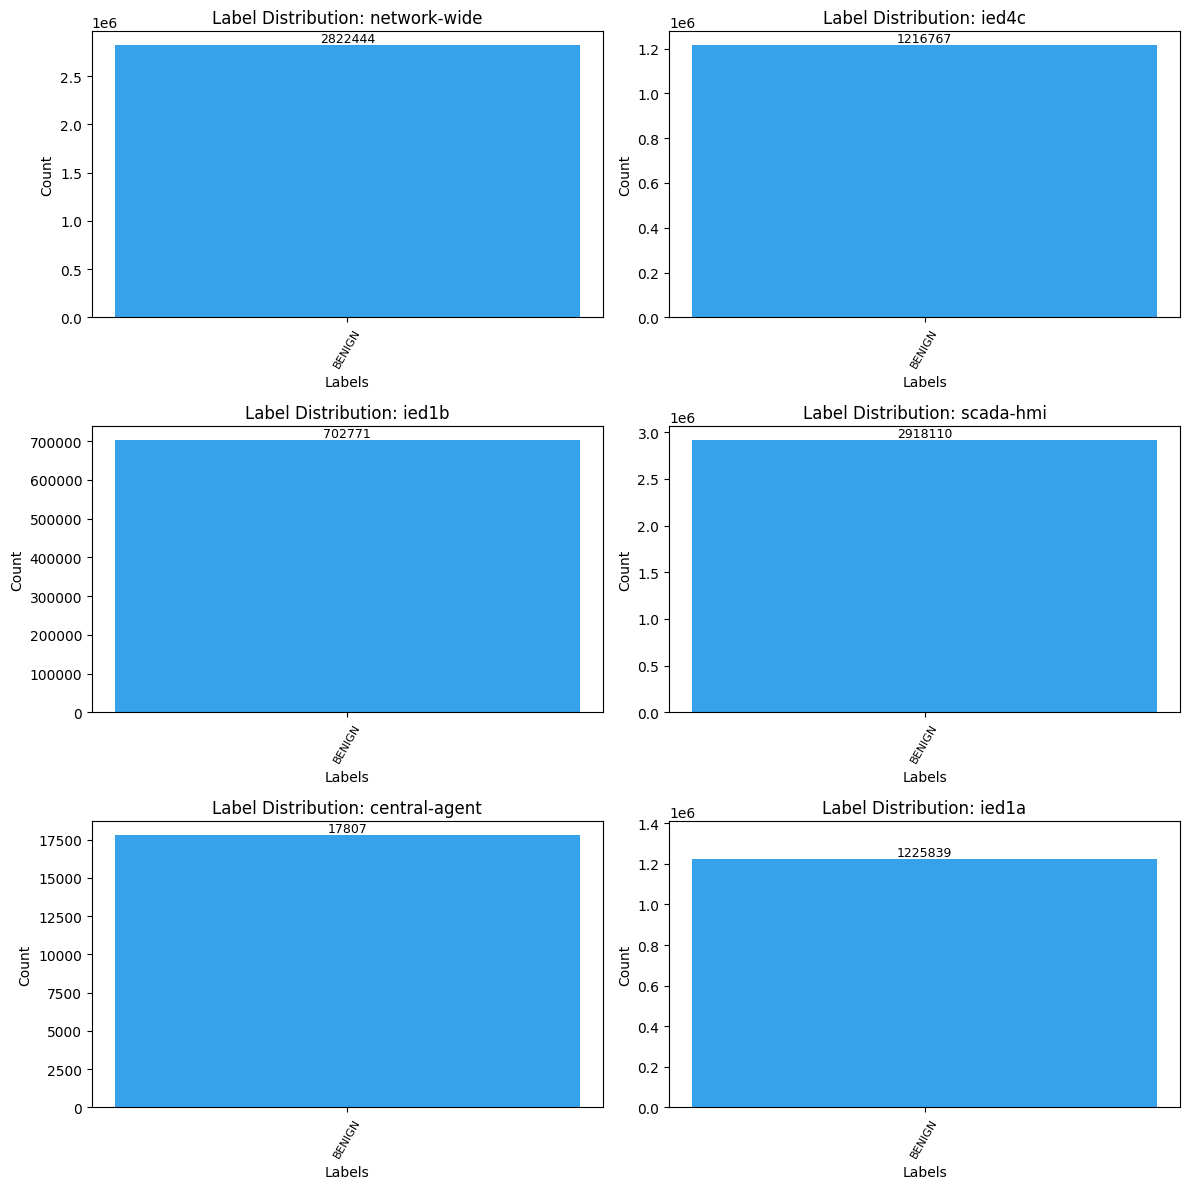

In [8]:

print_statistics(benign_global_stats)
plot_label_counts_subplots(benign_label_counts)


#### Compromised IED

-------------------------------------------------------------------------------- 
node_ 0  : ied4c 
flows count_ 949637.0
                                   mean          std   min            max  \
Protocol                           6.01         0.25  2.00          17.00   
Flow Duration               11306483.16  28013926.62  0.00   119990244.00   
Total Fwd Packet                   3.62         2.57  0.00         118.00   
Total Bwd packets                  2.98         1.79  0.00          61.00   
Total Length of Fwd Packet        18.42       207.76  0.00       15409.00   
Total Length of Bwd Packet         6.97        16.16  0.00        1159.00   
Fwd Packet Length Max              8.11        16.80  0.00         700.00   
Fwd Packet Length Min              0.03         1.71  0.00         118.00   
Fwd Packet Length Mean             1.89         8.33  0.00         175.00   
Fwd Packet Length Std              3.60         8.49  0.00         350.00   
Bwd Packet Length Max          

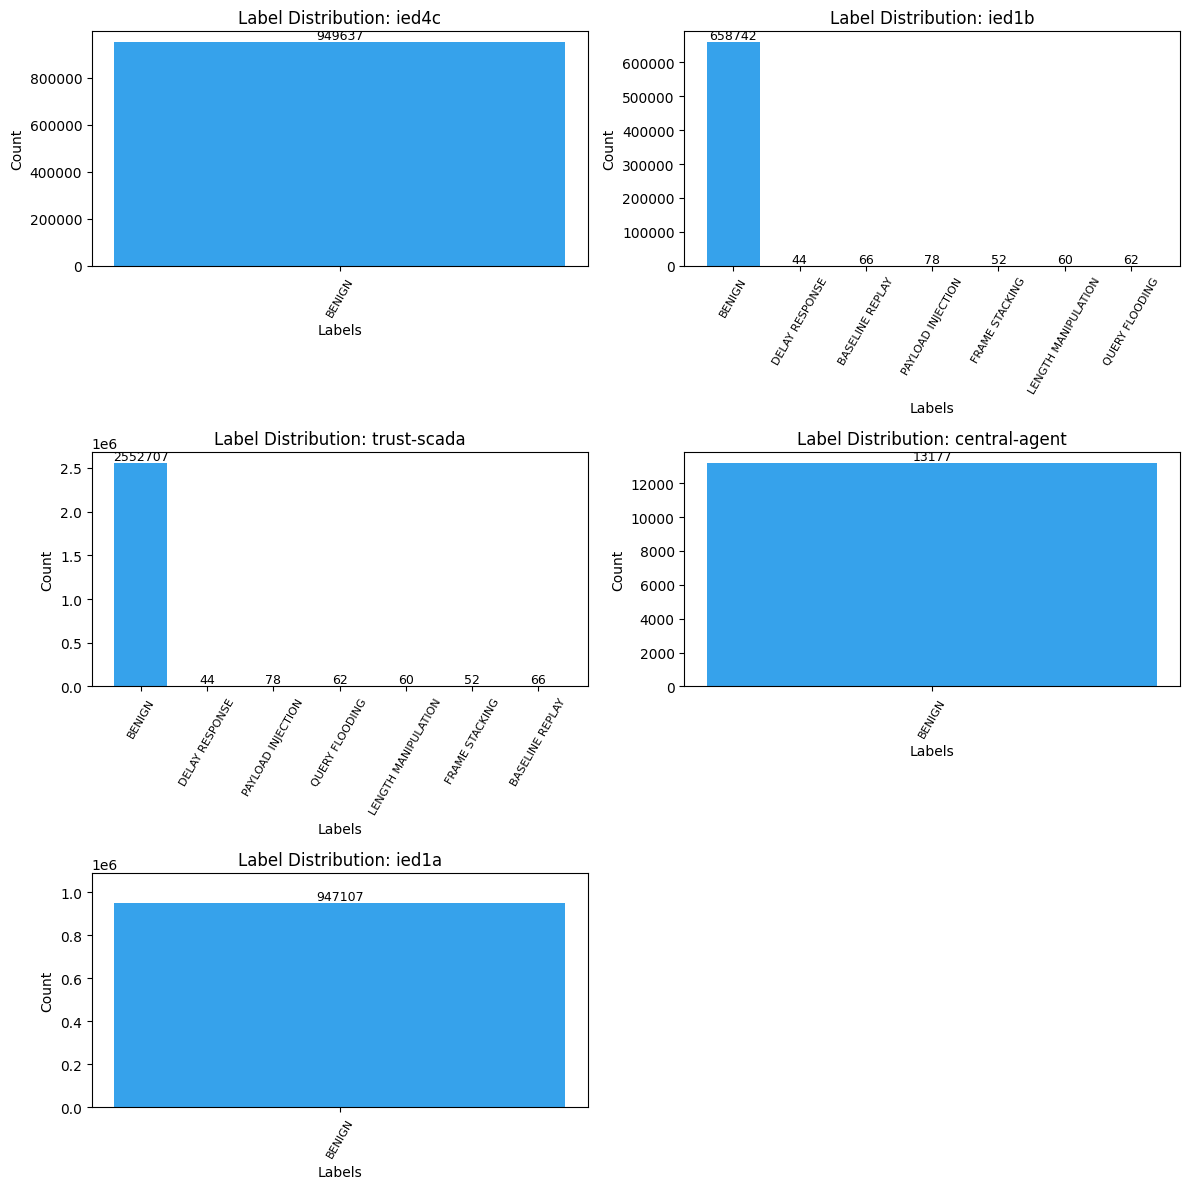

In [7]:

print_statistics(com_ied_global_stats)
plot_label_counts_subplots(com_ied_label_counts)


#### Compromised SCADA

-------------------------------------------------------------------------------- 
node_ 0  : ied4c 
flows count_ 839426.0
                                   mean           std   min             max  \
Protocol                           6.01          0.27  2.00           17.00   
Flow Duration               10097713.06   25868605.09  0.00    119999661.00   
Total Fwd Packet                   3.90          5.57  0.00          182.00   
Total Bwd packets                  3.14          3.12  0.00           99.00   
Total Length of Fwd Packet        46.01        711.73  0.00        25021.00   
Total Length of Bwd Packet         8.15         53.48  0.00         1881.00   
Fwd Packet Length Max              8.55         16.99  0.00          718.00   
Fwd Packet Length Min              0.04          1.88  0.00          118.00   
Fwd Packet Length Mean             2.04          8.51  0.00          179.50   
Fwd Packet Length Std              3.83          8.40  0.00          359.00   
Bwd Packe

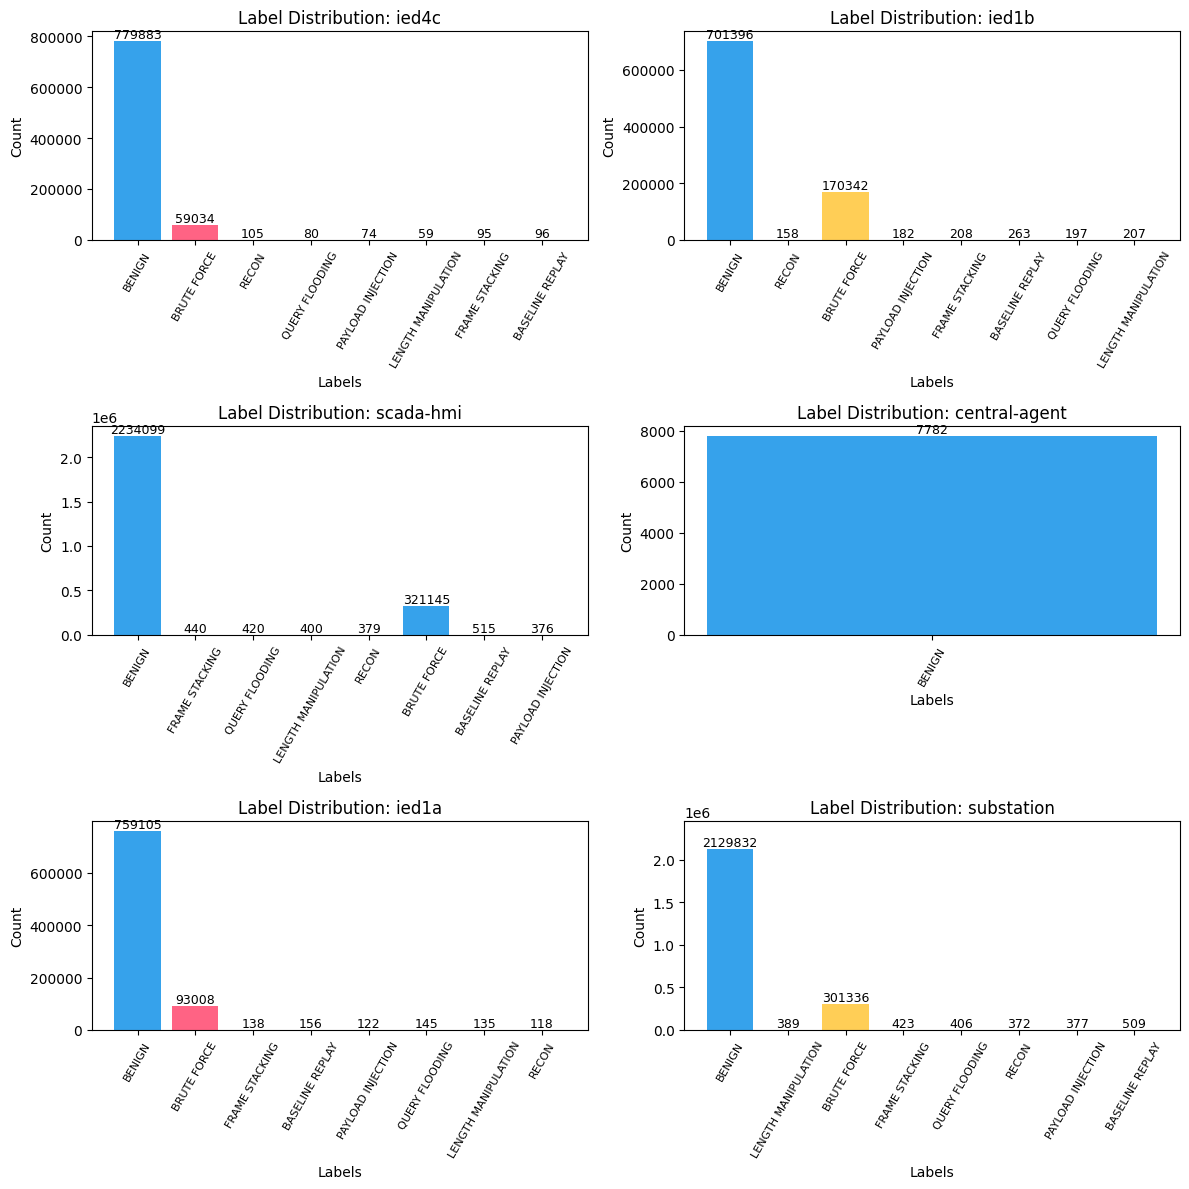

In [9]:

print_statistics(com_scd_global_stats)
plot_label_counts_subplots(com_scd_label_counts)


#### Torch custom dataset and dataloader

In [10]:


class CSVDataset(Dataset):
    def __init__(
        self,
        csv_files: List[str],
        chunk_size: int = 5,
        batch_size: int = 64, 
        scalers: dict = None  # Changed to accept a dictionary of scalers
    ):
        """
        Custom PyTorch Dataset for reading multiple CSV files in chunks with preprocessing and scaling.

        Args:
            csv_files: List of paths to CSV files
            chunk_size: Number of files to process in one chunk (default: 5)
            scalers: Dictionary of fitted scalers (MinMaxScaler or StandardScaler) for each numeric feature column.
        """
        self.csv_files = csv_files
        self.csv_files_len = len(csv_files)
        self.chunk_size = chunk_size
        self.batch_size = batch_size  
        self.label_column = 'Label'
        self.protocol_column = 'Protocol'
        self.scalers = scalers  

        self.file_order_indices = list(range(self.csv_files_len))
        random.shuffle(self.file_order_indices) 
        self.current_file_idx = 0 

        self.current_chunk_data = None
        self.current_chunk_labels = None
        self.current_row_in_chunk_idx = 0 # Index within the currently loaded chunk

        self.unuseful_features = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp','end_time']
        
        # Determine numeric columns for scaling once during initialization
        self.numeric_cols_to_scale =[]
        self.determine_numeric_cul()
        # Initialize LabelEncoder and OneHotEncoder
        self.label_encoder = LabelEncoder()
        self.protocol_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self._fit_encoders()

        # Precalculate total rows and total batches
        self.total_samples = self._calculate_total_rows()
        
        self.total_batches = int(np.ceil(self.total_samples / self.batch_size))

        self._load_next_chunk() # Load the first chunk of data

    def determine_numeric_cul(self):    
        if self.csv_files_len > 0:
            # call once in __init__ function
            # Read a small portion of the first file to infer dtypes and columns
            # This assumes the column structure and data types are consistent across all CSVs.
            try:
                temp_df = pd.read_csv(self.csv_files[0], encoding='cp1252', nrows=100, low_memory=False)
                
                relevant_cols = [col for col in temp_df.columns if col not in self.unuseful_features]
                
                # Filter for numeric types and exclude label/protocol columns
                self.numeric_cols_to_scale = [
                    col for col in relevant_cols
                    if pd.api.types.is_numeric_dtype(temp_df[col]) and col not in [self.label_column, self.protocol_column]
                ]
            except Exception as e:
                print(f"Warning: Could not infer numeric columns from first CSV file. Error: {e}")
                print("Proceeding without pre-calculated numeric columns for scaling, this may lead to slower preprocessing.")

    def _fit_encoders(self):
        """
        Fit LabelEncoders for 'Label' and OneHotEncoder for 'Protocol' based on known unique values.
        """
        label_values = ['BASELINE REPLAY', 'PAYLOAD INJECTION', 'FRAME STACKING', 'QUERY FLOODING', 'RECON',
                        'BRUTE FORCE', 'BENIGN', 'DELAY RESPONSE', 'LENGTH MANIPULATION']
        # OneHotEncoder expects a 2D array, even for a single feature
        protocol_values = np.array([17, 2, 6]).reshape(-1, 1)
        self.label_encoder.fit(label_values)
        self.protocol_encoder.fit(protocol_values)

    def _preprocess_chunk(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Apply scaling to numeric columns using the provided dictionary of scalers.

        Args:
            df (pd.DataFrame): The DataFrame chunk to preprocess.

        Returns:
            pd.DataFrame: The preprocessed DataFrame.
        """

        if self.scalers:
            ## assume the same columns in all csv files.
            for col in self.numeric_cols_to_scale:
                if col in self.scalers: # Ensure a scaler exists for the current column
                    # Apply the specific scaler for this column
                    # .transform expects a 2D array, hence df[[col]]
                    df[col] = self.scalers[col].transform(df[[col]].values)
        return df

    def _load_next_chunk(self):
        """
        Loads the next chunk of CSV files into memory based on the shuffled file indices,
        preprocesses, encodes, and converts data to PyTorch Tensors.
        Handles reshuffling of file indices when all files have been processed (end of an internal "epoch").
        """
        # If all files from the current shuffled order have been processed, reshuffle for the next epoch
        if self.current_file_idx >= self.csv_files_len:
            self.file_order_indices = list(range(self.csv_files_len))
            random.shuffle(self.file_order_indices)
            self.current_file_idx = 0 

        start_idx_in_order = self.current_file_idx
        end_idx_in_order = min(start_idx_in_order + self.chunk_size, self.csv_files_len)

        chunk_file_paths = [self.csv_files[self.file_order_indices[i]] for i in range(start_idx_in_order, end_idx_in_order)]

        if chunk_file_paths:
            # Concat CSV files, dropping unuseful features
            if chunk_file_paths ==1 :
                chunk_df = pd.read_csv(chunk_file_paths, encoding='cp1252',
                                                usecols=self.numeric_cols_to_scale.extend(self.label_column), low_memory=False) 
            else :
                chunk_df = pd.concat([pd.read_csv(file, encoding='cp1252',
                                                usecols=lambda column: column not in self.unuseful_features, low_memory=False) for file in chunk_file_paths],
                                                ignore_index=True)

            chunk_df[self.label_column] = self.label_encoder.transform(chunk_df[self.label_column])

            
            # Convert to numpy array to avoid the UserWarning about feature names
            protocol_encoded_array = self.protocol_encoder.transform(chunk_df[[self.protocol_column]].values)
            chunk_df.drop(columns=[self.protocol_column], inplace=True)
            chunk_df[[f'Protocol_{int(cat)}' for cat in self.protocol_encoder.categories_[0]]] = protocol_encoded_array

            chunk_df = self._preprocess_chunk(chunk_df)
            self.current_chunk_data = tensor(chunk_df.drop(columns=[self.label_column],inplace=False).values, dtype=float32)
            self.current_chunk_labels = tensor(chunk_df[self.label_column].values, dtype=int32)

            self.current_file_idx = end_idx_in_order
            self.current_row_in_chunk_idx = 0  # Reset row index within the new chunk
        else:
            self.current_chunk_data = None
            self.current_chunk_labels = None

    def _calculate_total_rows(self) -> int:
        """
        Calculates the total number of samples across all CSV files.
        This is called once during initialization.
        """
        total_rows = 0
        for file in self.csv_files:
            # Read only the label column to quickly get the row count
            total_rows += len(pd.read_csv(file, usecols=[self.label_column], encoding='cp1252', low_memory=False))
        return total_rows

    def __len__(self) -> int:
        """
        Returns the total number of batches available for a DataLoader with batch_size=1.
        This value is precalculated in the __init__ method.
        """
        return self.total_batches

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        """
        This method internally manages loading fixed-size batches (self.batch_size=64) from chunks.
        The `idx` parameter from DataLoader is used by DataLoader for tracking progress,
        but not directly for selecting data within this Dataset's internal logic.

        Args:
            idx (int): Index provided by the DataLoader.

        Returns:
            Tuple[Tensor, Tensor]: A tuple containing (features_tensor, labels_tensor) for the batch.
        """
        if self.current_chunk_data is None:
            # If current_chunk_data is None, it means there are no more files to process
            # in the current shuffled order (or globally). This signals end of iteration.
            raise StopIteration("No more data chunks to load.")

        ## get the length of the torch tensor 
        current_len_chunk_data = len(self.current_chunk_data)

        # Calculate the end index for the current batch within the current chunk.
        # It takes `self.batch_size` samples, or fewer if close to the end of the chunk.
        end_idx = min(self.current_row_in_chunk_idx + self.batch_size, current_len_chunk_data)

        # Slice the data and labels directly from the pre-converted tensors
        features = self.current_chunk_data[self.current_row_in_chunk_idx:end_idx]
        labels = self.current_chunk_labels[self.current_row_in_chunk_idx:end_idx]

        # Update the starting index for the next batch within the current chunk
        self.current_row_in_chunk_idx = end_idx

        # If we have processed all rows in the current chunk, load the next chunk of files
        if self.current_row_in_chunk_idx >= current_len_chunk_data:
            self._load_next_chunk() # This call will also handle reshuffling for the next epoch if needed

        return features, labels



#### Ensure correct  Shuffling and Min Max interval after scaling [0 to 1]

##### The Analysis are on ied1b node dataset (compromised-scada scenario) because of having enough samples for diverse Categories

In [14]:
### for test performance of the machine learning algorithms on all attack categories (except Delay Response) 
### ied1b node of the compromised-scada scenario is suitable
csv_files=[col for col in modbus.dataset["attack_dataset_dir"]["compromised-scada"] if col.find("ied1b")!=-1]
print("ied1b number of csv files :",len(csv_files),csv_files)

dataset = CSVDataset(csv_files=csv_files, chunk_size=5, scalers=benign_scalers["network-wide"]["min_max_scalers"])
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
print(f"Total batches in the dataset: {len(dataloader)}")
num_epochs = 3 # Example: Train for 3 epochs
start_time =time.time()
for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch + 1}/{num_epochs} ---")

    start_time =time.time()
    for batch_idx, (features, labels) in enumerate(dataloader):
        # 'features' will be a tensor of shape (batch_size, num_features)
        # 'labels' will be a tensor of shape (batch_size,)
        # Where batch_size is 64 (or less for the final batch in a chunk/dataset)

        print(f"  Batch {batch_idx + 1}: Features {features[0][0] }, Labels shape={labels.shape}")
        time.sleep(0.001)
        break

    print(f"Elapsed time: {(time.time() - start_time) * 1000:.2f} ms")


ied1b number of csv files : 8 ['./dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-6-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-3-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-4-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-1-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-7-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-0-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-5-labeled.csv', './dataset/ModbusDataset/attack/compromised-scada/ied1b/ied1b-network-captures/ready/vethc76bd3f-2-labeled.csv']
Total batches in the dataset: 13640

--- Epoch 1/3 ---
  Batch 1:

#### Multi-class Classification with the Classic Machine Learning 

##### Machine learning models Used

- Gaussian Naive Bayes (GaussianNB)
- Random Forest
- Decision Tree
- Gradient Boosting
- linear SVM
- Logistic Regression
- KNN

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import seaborn as sns


# Function to plot the confusion matrix heatmap
def plot_confusion_matrix(y_true, y_pred, label_encoder, title="Confusion Matrix"):
    """
    Plots a confusion matrix as a heatmap.

    Args:
        y_true (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted labels.
        label_encoder (LabelEncoder): The fitted LabelEncoder.
        title (str): Title for the plot.
    """
    # Get all possible encoded classes to ensure the matrix is square and complete
    all_classes_encoded = np.arange(len(label_encoder.classes_))
    cm = confusion_matrix(y_true, y_pred, labels=all_classes_encoded)
    
    # Get the original label names for ticks
    class_names = label_encoder.inverse_transform(all_classes_encoded)

    # Normalize the confusion matrix for better interpretability (optional)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized) # Replace NaNs (from divisions by zero) with 0

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=True,      # Annotate cells with values
        fmt=".2f",       # Format annotations to 2 decimal places
        cmap="Blues",    # Color map
        cbar=True,       # Show color bar
        xticklabels=class_names, # X-axis labels (predicted)
        yticklabels=class_names  # Y-axis labels (true)
    )
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
    plt.yticks(rotation=0)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()


base_models = [
    LogisticRegression(random_state=0,max_iter=200),
    LinearSVC( random_state=0),
    GaussianNB(),
    RandomForestClassifier(n_estimators=50, random_state=0),
    DecisionTreeClassifier(random_state=0,criterion='gini'),
    DecisionTreeClassifier(random_state=0,criterion='entropy'),
    KNeighborsClassifier(n_neighbors=3),
    HistGradientBoostingClassifier( learning_rate=0.1, random_state=0)
]

shuffle=True
random_seed =42
train_ratio=0.8
valid_ratio = 1-train_ratio

# Set random seed if shuffling
if shuffle:
    random.seed(random_seed)
    random.shuffle(csv_files)


# Initialize datasets
train_dataset = CSVDataset(
    csv_files=csv_files,chunk_size=1,scalers=benign_scalers["network-wide"]["min_max_scalers"]
)
train_dataloader =DataLoader(train_dataset, batch_size=1, shuffle=False)


# Extract data and labels
def np_from_dataloader(_dataloader):
    data_list = []
    labels_list = []
    for batch_x, batch_y in _dataloader:
        data_list.append(batch_x.numpy())
        labels_list.append(batch_y.numpy())
    # Convert lists to NumPy arrays
    X_np = np.concatenate(data_list, axis=1)
    y_np = np.concatenate(labels_list, axis=1)
    return X_np.squeeze(0),y_np.squeeze(0)



def train_evaluate(base_models,features,labels):
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size = 0.25, random_state = 0)

    for i, model in enumerate(base_models):
        print(f"\n--- Training Base Model {i+1} ---{model}")
        model.fit(X_train, y_train)
        
        print(f"--- Evaluating Base Model {i+1} ---{model} on Validation Set ---")
        y_pred = model.predict(X_val)
        
        print(f"Accuracy of Base Model {i+1}: ---{model}  {accuracy_score(y_val, y_pred):.4f}")
        
        #ensures that all 9 classes are considered, even if some are missing in y_val/y_pred
        print(classification_report(y_val, y_pred, 
                                    labels=np.arange(len(train_dataset.label_encoder.classes_)), 
                                    target_names=list(train_dataset.label_encoder.classes_), 
                                    zero_division=np.nan))
        # Plotting the confusion matrix heatmap
        plot_confusion_matrix(y_val, y_pred, train_dataset.label_encoder, 
                            title=f"Confusion Matrix for Base Model {i+1} ---{model} ")


In [27]:
X_train , y_train = np_from_dataloader(train_dataloader)

print("total batches of the train_dataset",train_dataset.__len__())

unique_labels, counts = np.unique(y_train, return_counts=True)

print("train_dataset unbalanced label distribution before sampling")
for i in range(len(unique_labels)):
    print(f"Label {unique_labels[i]}: {counts[i]} ")
print("-" * 30)


total batches of the train_dataset 13640
train_dataset unbalanced label distribution before sampling
Label 0: 263 
Label 1: 701130 
Label 2: 170342 
Label 4: 208 
Label 5: 207 
Label 6: 182 
Label 7: 197 
Label 8: 158 
------------------------------


#### Training and Evaluation Loop 



--- Training Base Model 1 ---LogisticRegression(max_iter=200, random_state=0)


/home/hamid_rd3/labeling/Project1404/vnv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Evaluating Base Model 1 ---LogisticRegression(max_iter=200, random_state=0) on Validation Set ---
Accuracy of Base Model 1: ---LogisticRegression(max_iter=200, random_state=0)  0.8693
                     precision    recall  f1-score   support

    BASELINE REPLAY        nan      0.00      0.00        67
             BENIGN       0.94      0.90      0.92    175311
        BRUTE FORCE       0.64      0.76      0.69     42541
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       0.40      0.07      0.12        56
LENGTH MANIPULATION        nan      0.00      0.00        54
  PAYLOAD INJECTION        nan      0.00      0.00        54
     QUERY FLOODING       0.77      0.60      0.68        45
              RECON        nan      0.00      0.00        44

           accuracy                           0.87    218172
          macro avg       0.69      0.29      0.30    218172
       weighted avg       0.88      0.87      0.87    218172



/tmp/ipykernel_1418/336111938.py:33: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


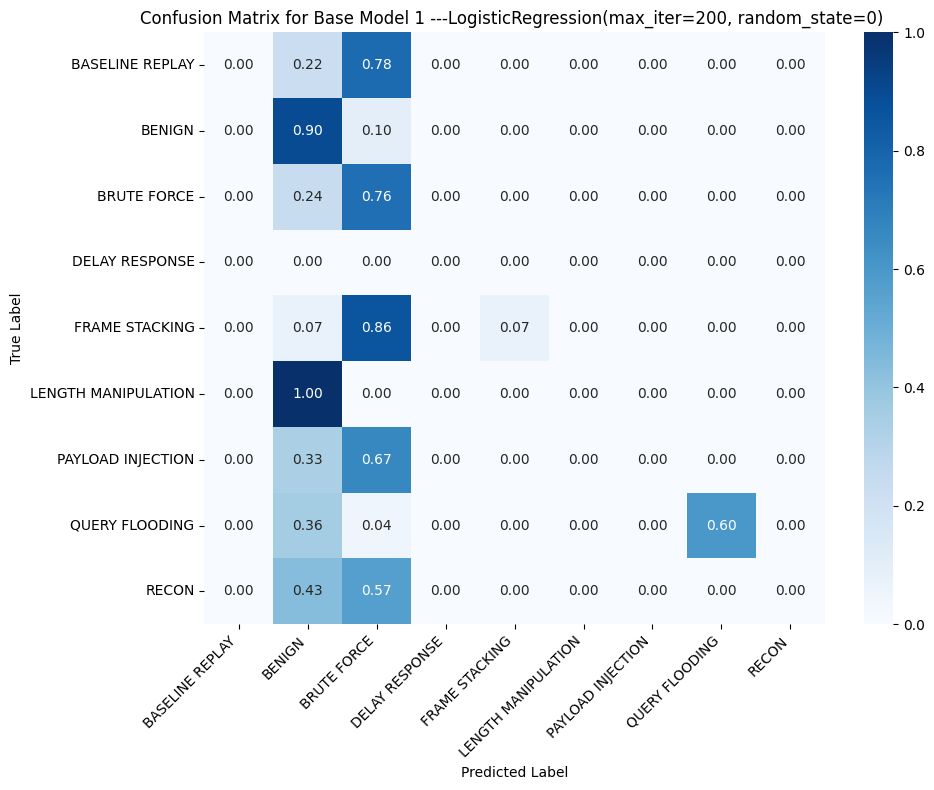


--- Training Base Model 2 ---LinearSVC(random_state=0)
--- Evaluating Base Model 2 ---LinearSVC(random_state=0) on Validation Set ---
Accuracy of Base Model 2: ---LinearSVC(random_state=0)  0.8700
                     precision    recall  f1-score   support

    BASELINE REPLAY        nan      0.00      0.00        67
             BENIGN       0.95      0.89      0.92    175311
        BRUTE FORCE       0.63      0.79      0.70     42541
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       0.36      0.07      0.12        56
LENGTH MANIPULATION       0.81      0.81      0.81        54
  PAYLOAD INJECTION        nan      0.00      0.00        54
     QUERY FLOODING       0.70      0.87      0.77        45
              RECON        nan      0.00      0.00        44

           accuracy                           0.87    218172
          macro avg       0.69      0.43      0.42    218172
       weighted avg       0.89      0.87      0.87    218172



/tmp/ipykernel_1418/336111938.py:33: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


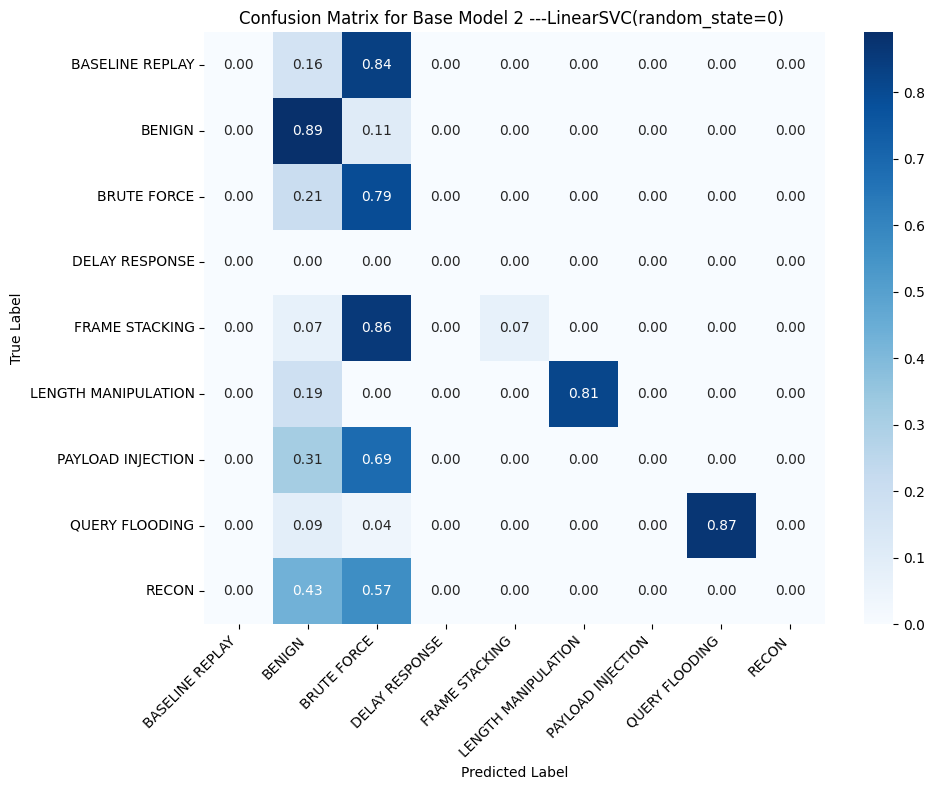


--- Training Base Model 3 ---GaussianNB()
--- Evaluating Base Model 3 ---GaussianNB() on Validation Set ---
Accuracy of Base Model 3: ---GaussianNB()  0.1952
                     precision    recall  f1-score   support

    BASELINE REPLAY        nan      0.00      0.00        67
             BENIGN        nan      0.00      0.00    175311
        BRUTE FORCE       0.20      1.00      0.33     42541
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       0.40      0.07      0.12        56
LENGTH MANIPULATION        nan      0.00      0.00        54
  PAYLOAD INJECTION        nan      0.00      0.00        54
     QUERY FLOODING       0.69      0.82      0.75        45
              RECON        nan      0.00      0.00        44

           accuracy                           0.20    218172
          macro avg       0.43      0.24      0.15    218172
       weighted avg       0.20      0.20      0.06    218172



/tmp/ipykernel_1418/336111938.py:33: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


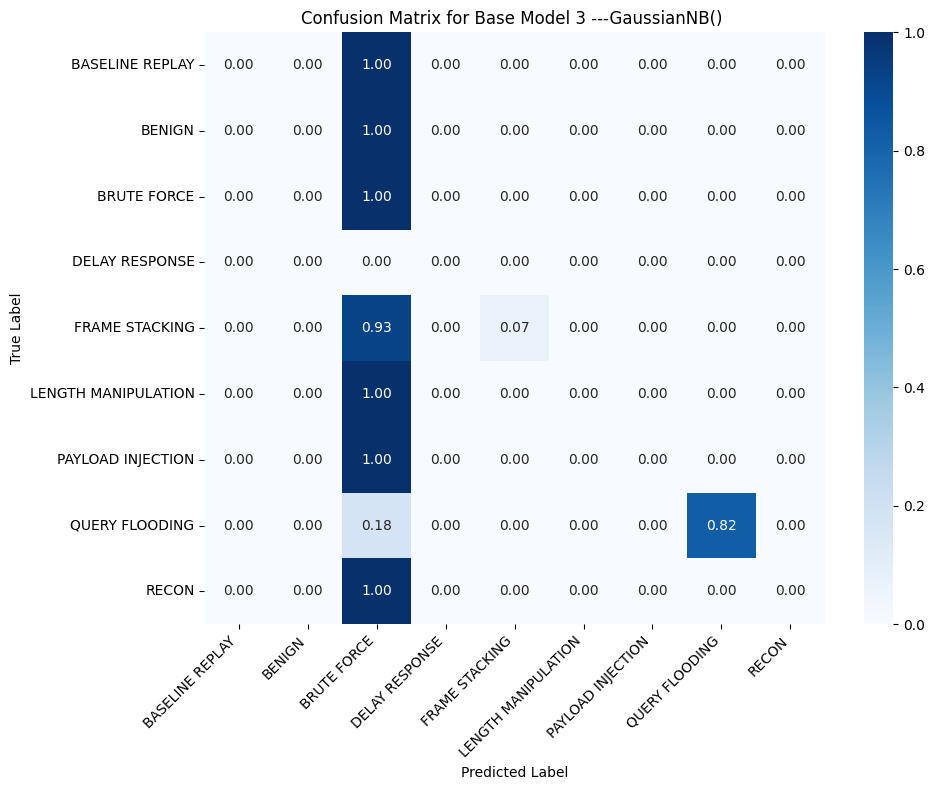


--- Training Base Model 4 ---RandomForestClassifier(n_estimators=50, random_state=0)
--- Evaluating Base Model 4 ---RandomForestClassifier(n_estimators=50, random_state=0) on Validation Set ---
Accuracy of Base Model 4: ---RandomForestClassifier(n_estimators=50, random_state=0)  0.8875
                     precision    recall  f1-score   support

    BASELINE REPLAY       0.56      0.60      0.58        67
             BENIGN       0.95      0.91      0.93    175311
        BRUTE FORCE       0.69      0.79      0.73     42541
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       0.75      0.89      0.81        56
LENGTH MANIPULATION       0.84      0.98      0.91        54
  PAYLOAD INJECTION       0.75      0.76      0.75        54
     QUERY FLOODING       0.73      0.80      0.77        45
              RECON       0.00      0.00      0.00        44

           accuracy                           0.89    218172
          macro avg       0.66      0.7

/tmp/ipykernel_1418/336111938.py:33: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


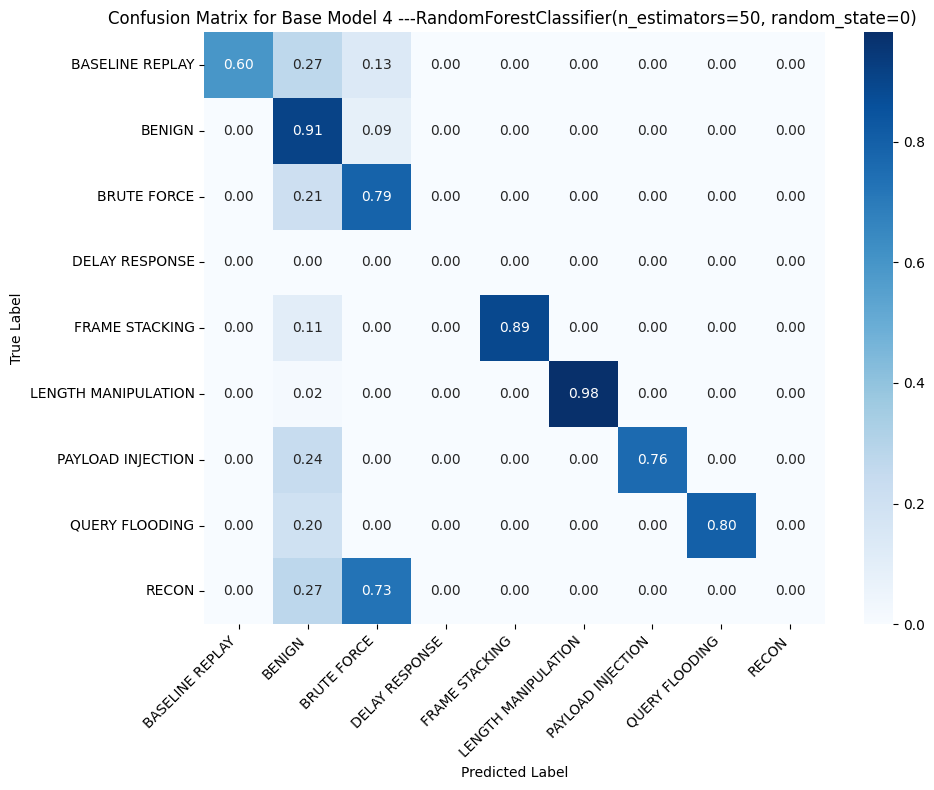


--- Training Base Model 5 ---DecisionTreeClassifier(random_state=0)
--- Evaluating Base Model 5 ---DecisionTreeClassifier(random_state=0) on Validation Set ---
Accuracy of Base Model 5: ---DecisionTreeClassifier(random_state=0)  0.8729
                     precision    recall  f1-score   support

    BASELINE REPLAY       0.46      0.45      0.45        67
             BENIGN       0.92      0.92      0.92    175311
        BRUTE FORCE       0.68      0.67      0.67     42541
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       0.76      0.75      0.76        56
LENGTH MANIPULATION       0.84      0.78      0.81        54
  PAYLOAD INJECTION       0.80      0.65      0.71        54
     QUERY FLOODING       0.82      0.71      0.76        45
              RECON       0.00      0.00      0.00        44

           accuracy                           0.87    218172
          macro avg       0.66      0.62      0.64    218172
       weighted avg       0.8

/tmp/ipykernel_1418/336111938.py:33: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


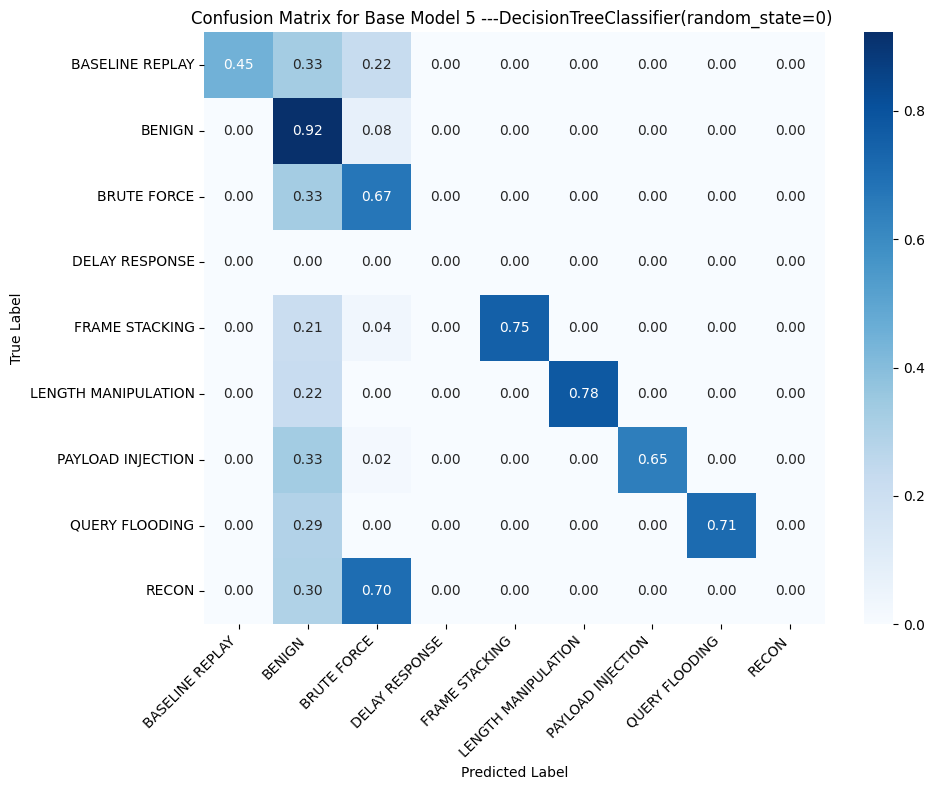


--- Training Base Model 6 ---DecisionTreeClassifier(criterion='entropy', random_state=0)
--- Evaluating Base Model 6 ---DecisionTreeClassifier(criterion='entropy', random_state=0) on Validation Set ---
Accuracy of Base Model 6: ---DecisionTreeClassifier(criterion='entropy', random_state=0)  0.8730
                     precision    recall  f1-score   support

    BASELINE REPLAY       0.51      0.57      0.54        67
             BENIGN       0.92      0.92      0.92    175311
        BRUTE FORCE       0.68      0.67      0.68     42541
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       0.73      0.79      0.76        56
LENGTH MANIPULATION       0.83      0.63      0.72        54
  PAYLOAD INJECTION       0.80      0.69      0.74        54
     QUERY FLOODING       0.85      0.64      0.73        45
              RECON       0.00      0.00      0.00        44

           accuracy                           0.87    218172
          macro avg       0

/tmp/ipykernel_1418/336111938.py:33: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


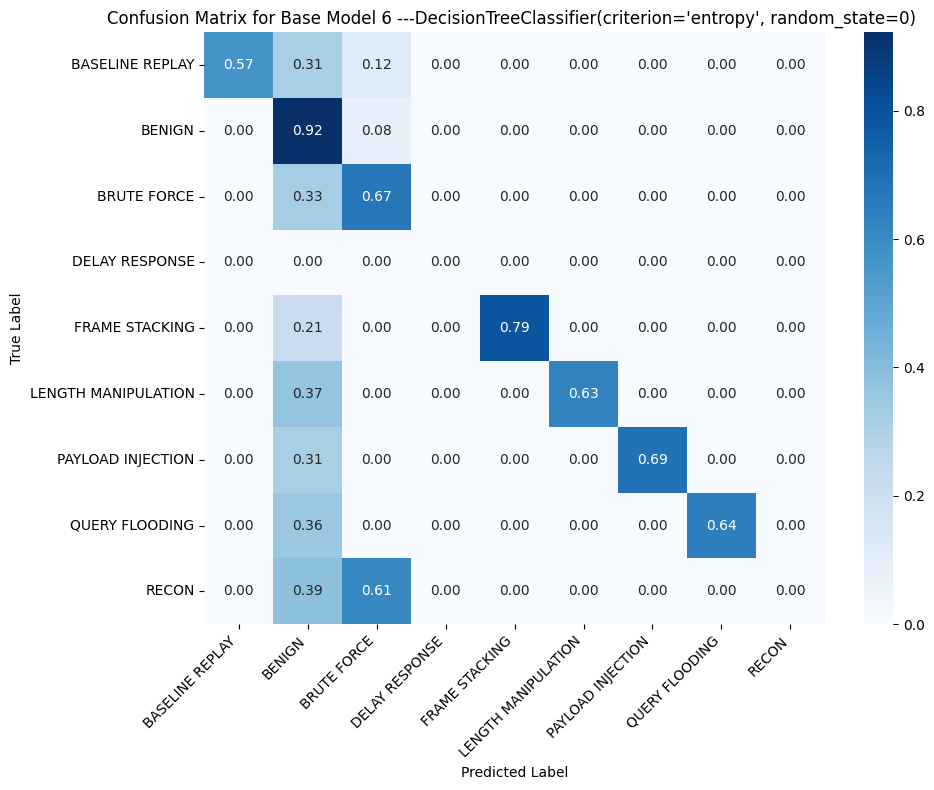


--- Training Base Model 7 ---KNeighborsClassifier(n_neighbors=3)
--- Evaluating Base Model 7 ---KNeighborsClassifier(n_neighbors=3) on Validation Set ---
Accuracy of Base Model 7: ---KNeighborsClassifier(n_neighbors=3)  0.8706
                     precision    recall  f1-score   support

    BASELINE REPLAY       0.49      0.61      0.55        67
             BENIGN       0.93      0.91      0.92    175311
        BRUTE FORCE       0.66      0.71      0.68     42541
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       0.78      0.91      0.84        56
LENGTH MANIPULATION       0.78      0.83      0.80        54
  PAYLOAD INJECTION       0.73      0.74      0.73        54
     QUERY FLOODING       0.71      0.67      0.69        45
              RECON        nan      0.00      0.00        44

           accuracy                           0.87    218172
          macro avg       0.73      0.67      0.65    218172
       weighted avg       0.88      0.

/tmp/ipykernel_1418/336111938.py:33: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


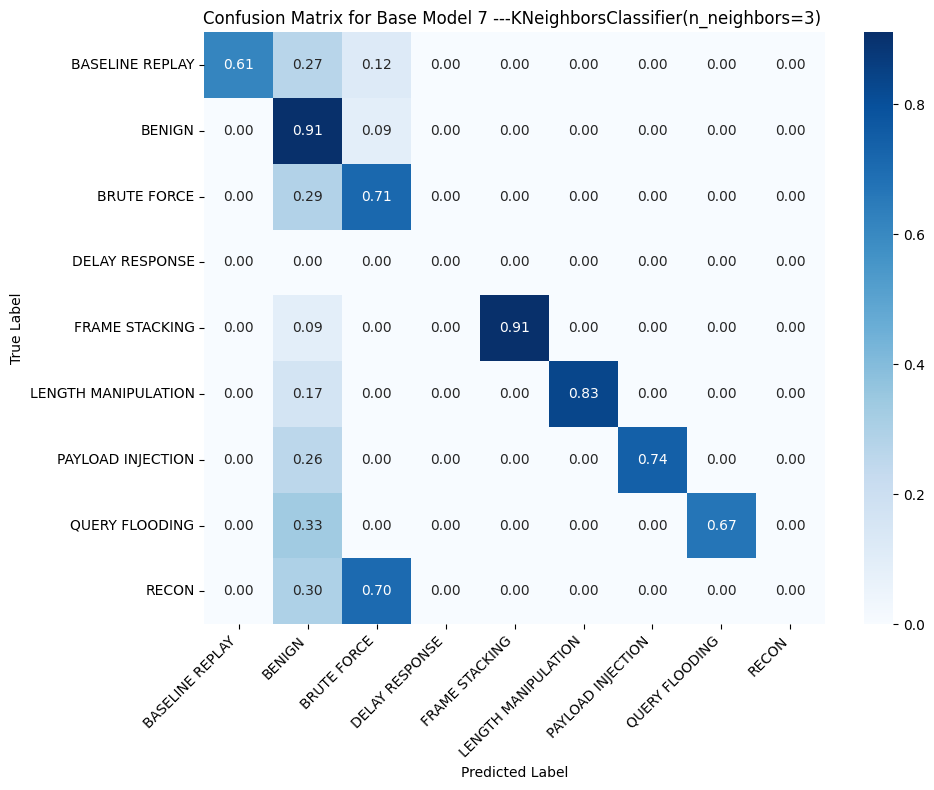


--- Training Base Model 8 ---HistGradientBoostingClassifier(random_state=0)
--- Evaluating Base Model 8 ---HistGradientBoostingClassifier(random_state=0) on Validation Set ---
Accuracy of Base Model 8: ---HistGradientBoostingClassifier(random_state=0)  0.8838
                     precision    recall  f1-score   support

    BASELINE REPLAY       0.20      0.25      0.23        67
             BENIGN       0.99      0.87      0.93    175311
        BRUTE FORCE       0.65      0.93      0.76     42541
     DELAY RESPONSE        nan       nan       nan         0
     FRAME STACKING       0.19      0.84      0.31        56
LENGTH MANIPULATION       0.72      0.63      0.67        54
  PAYLOAD INJECTION       0.12      0.52      0.19        54
     QUERY FLOODING       0.00      0.18      0.01        45
              RECON       0.00      0.00      0.00        44

           accuracy                           0.88    218172
          macro avg       0.36      0.53      0.39    218172
     

/tmp/ipykernel_1418/336111938.py:33: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


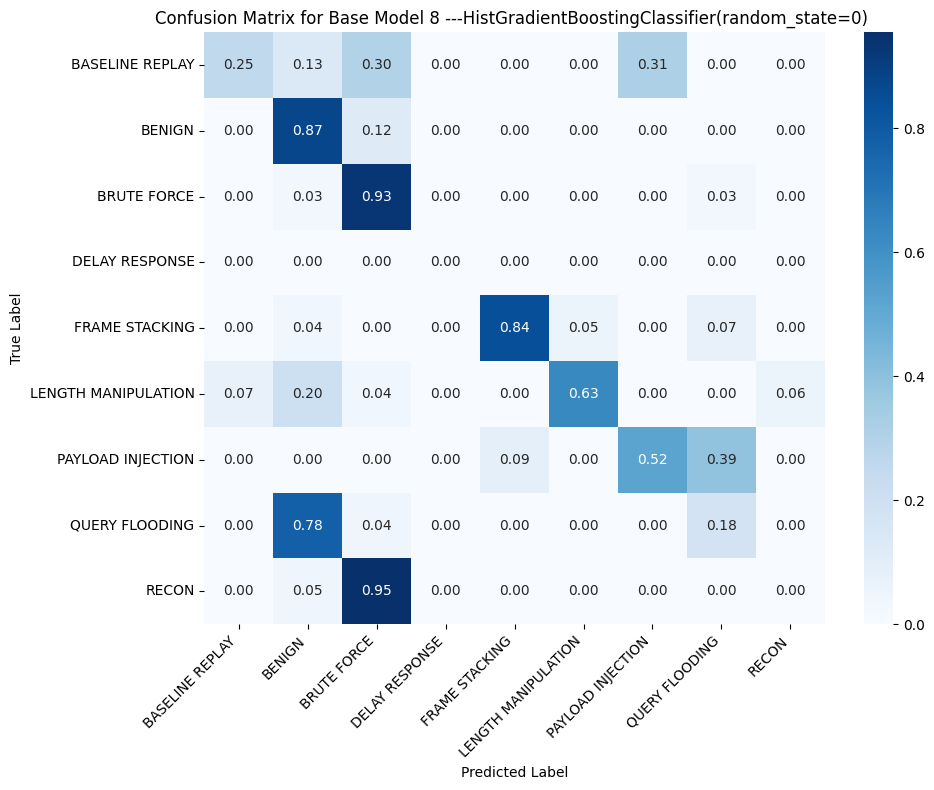

In [28]:
### Train on the original distribution
train_evaluate(base_models,X_train,y_train)

#### Creating a Balanced Dataset 



In [29]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy_rus = {
    0: 200,    
    1: 5000,  # Downsample Label 1 from 701102 to 5000
    2: 5000, # Downsample Label 1 from 170342 to 5000
    4: 208,    
    5: 207,    
    6: 182,    
    7: 197,    
    8: 158     
}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy_rus, random_state=42)
X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)
print("\nDistribution after RandomUnderSampler:")
print(dict(Counter(y_resampled_rus)))
print(f"Resampled X_train shape (RUS): {X_resampled_rus.shape}")
print(f"Resampled y_train shape (RUS): {y_resampled_rus.shape}")
print("-" * 50)

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_upsampled, y_upsampled = smote.fit_resample(X_resampled_rus, y_resampled_rus)

print("\nDistribution after SMOTE OverSampler:")
print(dict(Counter(y_upsampled)))
print(f"Resampled X_train shape (RUS): {X_upsampled.shape}")
print(f"Resampled y_train shape (RUS): {y_upsampled.shape}")
print("-" * 50)




Distribution after RandomUnderSampler:
{0: 200, 1: 5000, 2: 5000, 4: 208, 5: 207, 6: 182, 7: 197, 8: 158}
Resampled X_train shape (RUS): (11152, 89)
Resampled y_train shape (RUS): (11152,)
--------------------------------------------------

Distribution after SMOTE OverSampler:
{0: 5000, 1: 5000, 2: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000}
Resampled X_train shape (RUS): (40000, 89)
Resampled y_train shape (RUS): (40000,)
--------------------------------------------------


In [30]:
### Train on the Sampled distribution
train_evaluate(base_models,X_train,y_train)


--- Training Base Model 1 ---LogisticRegression(max_iter=200, random_state=0)


KeyboardInterrupt: 

In [ ]:


class CSVSplitDataset:
    def __init__(
        self,
        csv_files: List[str],
        train_ratio: float = 0.7,
        valid_ratio: float = 0.15,
        test_ratio: float = 0.15,
        chunk_size: int = 5,
        batch_size: int = 64,
        label_column: str = 'Label',
        protocol_column: str = 'Protocol',
        shuffle: bool = True,
        random_seed: int = 42
    ):
        """
        Wrapper class to split CSV files into train, validation, and test sets.
        
        Args:
            csv_files: List of paths to CSV files
            train_ratio: Proportion of files for training (default: 0.7)
            valid_ratio: Proportion of files for validation (default: 0.15)
            test_ratio: Proportion of files for testing (default: 0.15)
            chunk_size: Number of files to process in one chunk (default: 5)
            batch_size: Desired batch size (default: 64)
            label_column: Name of the label column in CSV
            protocol_column: Name of the protocol column in CSV
            shuffle: Whether to shuffle CSV files before splitting (default: True)
            random_seed: Seed for reproducibility (default: 42)
        """
        assert abs(train_ratio + valid_ratio + test_ratio - 1.0) < 1e-5, "Split ratios must sum to 100%"
        
        self.label_column = label_column
        self.protocol_column = protocol_column
        # Set random seed if shuffling
        if shuffle:
            random.seed(random_seed)
            random.shuffle(csv_files)
        
        # Split CSV files
        train_files, temp_files = train_test_split(
            csv_files,
            train_size=train_ratio,
            random_state=random_seed
        )
        valid_files, test_files = train_test_split(
            temp_files,
            train_size=valid_ratio / (valid_ratio + test_ratio),
            random_state=random_seed
        )

        # Fit scalers on training data
        min_max_scaler = MinMaxScaler()
        standard_scaler = StandardScaler()
        self._fit_scalers(train_files, min_max_scaler, standard_scaler)

        # Initialize datasets
        self.train_dataset = CSVDataset(
            train_files,
            chunk_size=chunk_size,
            batch_size=batch_size,
            label_column=label_column,
            protocol_column=protocol_column,
            min_max_scaler=min_max_scaler,
            standard_scaler=standard_scaler
        )
        self.valid_dataset = CSVDataset(
            valid_files,
            chunk_size=chunk_size,
            batch_size=batch_size,
            label_column=label_column,
            protocol_column=protocol_column,
            min_max_scaler=min_max_scaler,
            standard_scaler=standard_scaler
        )
        self.test_dataset = CSVDataset(
            test_files,
            chunk_size=chunk_size,
            batch_size=batch_size,
            label_column=label_column,
            protocol_column=protocol_column,
            min_max_scaler=min_max_scaler,
            standard_scaler=standard_scaler
        )


In [ ]:
# 3. Initialize CSVDataset
print("\n--- Initializing CSVDataset ---")
try:
    dataset = CSVDataset(modbus.dataset['attack_dataset_dir']['external'],benign_scalers["network-wide"]["min_max_scalers"])

    print("CSVDataset initialized successfully.")
except Exception as e:
    print(f"Error initializing CSVDataset: {e}")

print(f"\nTotal number of samples: {len(dataset)}")
sample_indices_to_test = [0, 49, 50, 99]
for i, idx in enumerate(sample_indices_to_test):
    try:
            features, label = dataset[idx]
            print(f"\nSample {idx}:")
            print(f"  Features shape: {features.shape}, dtype: {features.dtype}")
            print(f"  Label value: {label}, dtype: {label.dtype}")
            # You can add more detailed assertions here, e.g., check expected ranges after scaling
            # For example, MinMax scaled features should be between 0 and 1
            # Standard scaled features should have mean ~0 and std ~1 (over the whole dataset)

            # Example: Check if numeric features are floats and label is an int
            assert features.dtype == float32, f"Features dtype mismatch for sample {idx}"
            assert label.dtype == int32, f"Label dtype mismatch for sample {idx}"

            # Verify feature dimension is correct (num_numeric_cols + num_protocol_categories)
            num_protocol_categories = len(dataset.protocol_onehot_encoder.categories_[0])
            expected_feature_dim = len(numeric_cols) + num_protocol_categories
            assert features.shape[0] == expected_feature_dim, \
                   f"Feature dimension mismatch for sample {idx}. Expected {expected_feature_dim}, got {features.shape[0]}"
            print(f"  Sample {idx} retrieved and processed successfully.")

    except IndexError as e:
        print(f"Caught expected IndexError for index {idx} if out of bounds: {e}")
    except Exception as e:
        print(f"Error retrieving sample {idx}: {e}")
        raise # Re-raise to see the full traceback

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np

# # Define LSTM classifier model


# class LSTMClassifier(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size):
#         super(LSTMClassifier, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size,
#                             num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(
#             0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(
#             0), self.hidden_size).to(x.device)
#         out, _ = self.lstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out


# # Generate sample data
# # 100 sequences of length 10 with 50 features each
# X_train = np.random.rand(100, 10, 50)
# y_train = np.random.randint(2, size=(100,))  # Binary labels (0 or 1)

# # Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# # Define model parameters
# input_size = X_train.shape[2]
# hidden_size = 64
# num_layers = 2
# output_size = 2

# # Instantiate the model
# model = LSTMClassifier(input_size, hidden_size, num_layers, output_size)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# print(model)
# # # Train the model
# # num_epochs = 10
# # for epoch in range(num_epochs):
# #     optimizer.zero_grad()
# #     outputs = model(X_train_tensor)
# #     loss = criterion(outputs, y_train_tensor)
# #     loss.backward()
# #     optimizer.step()
# #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# # # Example of making predictions (not included in the final blog post)
# # X_test = np.random.rand(10, 10, 50)  # Test data with 10 sequences
# # X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# # with torch.no_grad():
# #     predictions = model(X_test_tensor)
# #     predicted_labels = torch.argmax(predictions, dim=1)
# #     print("Predicted Labels:", predicted_labels)
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import numpy as np

# Generate a sample dataset with 3 classes
X, y = make_classification(n_samples=1000, n_features=20,
                           n_informative=15, n_redundant=5, n_classes=3, random_state=1)


In [ ]:
print(y)

In [ ]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Define and train 7 base models (replace with your GRUs in practice)
base_models = [
    LogisticRegression(random_state=0),
    SVC(probability=True, random_state=0),
    GaussianNB(),
    RandomForestClassifier(n_estimators=50, random_state=0),
    LogisticRegression(random_state=1),
    SVC(probability=True, random_state=1),
    GaussianNB()
]

# Train each base model
for model in base_models:
    model.fit(X_train, y_train)

# Get probability predictions from each base model on training data
proba_train = [model.predict_proba(X_train) for model in base_models]
X_meta_train = np.hstack(proba_train)  # Shape: (n_samples, 7 * n_classes)

# Train the random forest meta-model
meta_model = RandomForestClassifier(n_estimators=100, random_state=42)
meta_model.fit(X_meta_train, y_train)

# Get probability predictions on test data
proba_test = [model.predict_proba(X_test) for model in base_models]
X_meta_test = np.hstack(proba_test)

# Make final predictions
y_pred = meta_model.predict(X_meta_test)

# Evaluate
print(f"Accuracy of the meta-model: {accuracy_score(y_test, y_pred):.4f}")
